# Q-Network Learning: Keras implimentation: Naive Implementation

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Load the environment

In [2]:
env = gym.make('FrozenLake-v0')

## The Q-Network Approach

### Implementing the network itself 

In [3]:
def feature(s, a):
    x = np.zeros((1, 16 + 4))
    x[0, s] = 1
    x[0, 16 + a] = 1
    return x

def calculate_q(model, s):
    q = np.zeros((4, ))
    x = np.zeros((4, 16 + 4))
    for a in range(4):
        x[a, s] = 1
        x[a, 16 + a] = 1
    return model.predict(x).ravel()

In [4]:
def build_model():
    model = keras.Sequential([
        layers.Dense(3, input_shape=[16 + 4]),
        layers.Dense(1, use_bias=False)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.1)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [5]:
model = build_model()
model.summary()

W0826 15:49:41.804254 139879527540544 deprecation.py:506] From /home/alexey/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 63        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


### Training the network

In [6]:
# Set learning parameters
y = 0.99
e = 0.1
num_episodes = 1000

for n in range(3):
    jList = []
    rList = []
    simulate = []
    for i in tqdm.tqdm(range(num_episodes)):
        # Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # The Q-Network
        while j < 99:
            j += 1
            # Choose an action by greedily (with e chance of random action) from the Q-network
            q = calculate_q(model, s)
            a = np.argmax(q)
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            # Get new state and reward from environment
            s1, r, d, _ = env.step(a)
            q1 = calculate_q(model, s1)
            v = r + y * np.max(q1)
            simulate.append((s, a, v))
            rAll += r
            s = s1
            if d == True:
                break
        jList.append(j)
        rList.append(rAll)
    # Trane the data
    x_train = np.zeros((len(simulate), 16 + 4))
    for i, x in enumerate(simulate):
        x_train[i] = feature(x[0], x[1])
    y_train = np.array([x[2] for x in simulate])
    h = model.fit(x_train, y_train, epochs=1, verbose=0)
    # Reduce chance of random action as we train the model.
    e = 1.0 / ((n/50) + 10)
    print("Percent of succesful episodes: {}%".format(sum(rList) / num_episodes * 100))


  1%|          | 6/1000 [00:00<00:19, 50.10it/s]

Percent of succesful episodes: 3.5000000000000004%


  1%|          | 7/1000 [00:00<00:16, 59.15it/s]

Percent of succesful episodes: 3.1%


100%|██████████| 1000/1000 [00:16<00:00, 61.40it/s]


Percent of succesful episodes: 5.0%


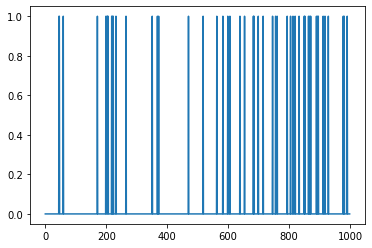

In [7]:
plt.plot(rList)

In [8]:
num_episodes = 1000
jList = []
rList = []

for i in tqdm.tqdm(range(num_episodes)):
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    while j < 99:
        j+=1
        q = calculate_q(model, s)
        a = np.argmax(q)
        s1, r, d, _ = env.step(a)
        q1 = calculate_q(model, s1)
        rAll += r
        s = s1
        if d:
            break
    jList.append(j)
    rList.append(rAll)

100%|██████████| 1000/1000 [00:14<00:00, 67.46it/s]


In [9]:
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.024%


## Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 750 episode mark.

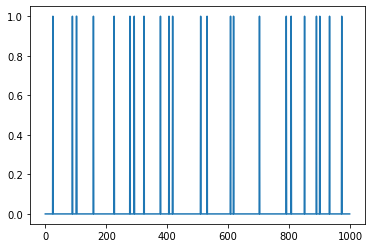

In [10]:
plt.plot(rList)

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well

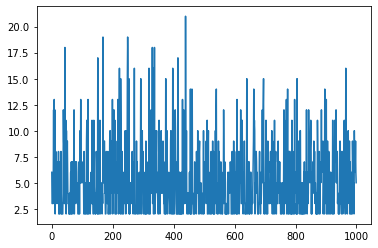

In [11]:
plt.plot(jList)